## Deutsch-Jozsa Algorithm
---

**Microcredential:** Introduction to Quantum Computing  
**Period:** January 2026

---

### Abstract
This notebook provides an implementation of the **Deutsch-Jozsa algorithm** using Qiskit. The project features a **parameterized architecture** capable of handling $n$-qubit to determine properties of functions in a single evaluation.

Components include:
* **Theoretical:** A mathematical breakdown of the exponential quantum speedup.
* **Dynamic Oracle:** Automated circuit generation for both constant and balanced functions.
* **Validation and Simulation:** Comprehensive testing using the **Aer** simulator to verify function types.

---

### Problem
Imagine a *black box* function (oracle) $f$ that takes a string of bits $\{0,1\}^n$ and spits out 0 or 1. We are guaranteed that the function is:
1.  **Constant:** It returns the same result (all 0s or all 1s) for every possible input.
2.  **Balanced:** It returns 0 for exactly half of the possible inputs and 1 for the other half.

The algorithm wants to determine if the function is **constant** or **balanced**.

* **Classical Method:** In the best case, you need 2 queries. However, to be 100% certain in the worst-case scenario, you would need $2^{n-1} + 1$ queries.
* **Quantum Method:** The Deutsch-Jozsa method figures this out with **just 1 step**.

The method uses quantum interference and phase kickback to identify the property of the function without checking individual inputs.

### Mathematical Breakdown
The algorithm evaluates all possible inputs simultaneously and uses interference to collapse the result into a measurable answer:

**1. Start:** Set up $n$ qubits to $|0\rangle$ and one auxiliary qubit (the *ancilla*) to $|1\rangle$:
$$|\psi_0\rangle = |0\rangle^{\otimes n} |1\rangle$$

**2. Superposition:** Apply a Hadamard gate ($H$) to all qubits. This creates a uniform superposition of all inputs and prepares for phase kickback:
$$|\psi_1\rangle = \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} |x\rangle \otimes \frac{|0\rangle - |1\rangle}{\sqrt{2}}$$

**3. Ask the Oracle:** The oracle $U_f$ maps $|x\rangle |y\rangle$ to $|x\rangle |y \oplus f(x)\rangle$. Because the ancilla is in the $|-\rangle$ state, the result is *kicked* into the phase:
$$|\psi_2\rangle = \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} (-1)^{f(x)} |x\rangle \otimes \frac{|0\rangle - |1\rangle}{\sqrt{2}}$$

**4. Interference:** Run $H^{\otimes n}$ again on the input. This turns the phase information back into information:
$$|\psi_3\rangle = \frac{1}{2^n} \sum_{i=0}^{2^n-1} \sum_{x=0}^{2^n-1} (-1)^{f(x) + x \cdot i} |i\rangle$$

In [ ]:
from IPython.display import clear_output

!pip install qiskit
!pip install qiskit_aer
!pip install pylatexenc
!pip install pandas

clear_output()
print("All dependencies installed successfully. Environment ready.")

All dependencies installed successfully. Environment ready.


In [ ]:
from qiskit import *
from qiskit.visualization import *
from qiskit_aer import AerSimulator

import numpy as np
import matplotlib.pyplot as plt

### Constant Oracle

Since the function must return the same value for every possible input, it does not actually *look* at the input qubits.

- Logic: The code randomly picks a binary output (0 or 1).

- Operation: If the output is 0, the circuit does nothing. If the output is 1, applied an X gate to the ancilla qubit.

- Function: Represents $f(x) = c$, where $c \in \{0, 1\}$.

$$U_f |x\rangle |y\rangle = |x\rangle |y \oplus c\rangle$$

Because the input $x$ never interacts with the ancilla, the phase of the input remains identical for every state, leading to constructive interference at $|0\rangle^{\otimes n}$.

In [ ]:
def dj_oracle_constant(n):
    oracle_qc = QuantumCircuit(n + 1)

    output = np.random.randint(2)
    if output == 1:
        oracle_qc.x(n)

    return oracle_qc

### Balanced Oracle

This function must return '1' for exactly half of the possible inputs and '0' for the other half.
- Logic: We use CNOT (CX) gates to create a dependency between the input register and the ancilla.

- The Operation: The code loops through each qubit in the input register.It uses each input qubit as a control and the ancilla as the target.

- Math: This effectively calculates the sum of the bits mod 2.

$$f(x) = \sum_{i=0}^{n-1} x_i \pmod 2$$

By using the input bits to flip, we ensure that for every state that results in 0, there is a corresponding flipped that results in 1.

In [ ]:
def dj_oracle_balanced(n):
    oracle_qc = QuantumCircuit(n + 1)
    for qubit in range(n):
        oracle_qc.cx(qubit, n)

    return oracle_qc

In [ ]:
def create_circuit(oracle_func,n_qubits):
  qc = QuantumCircuit(n_qubits + 1, n_qubits)

  qc.x(n_qubits)
  qc.h(range(n_qubits + 1))

  qc.barrier()
  oracle_qc = oracle_func(n_qubits)
  qc.compose(oracle_qc, inplace=True)
  qc.barrier()

  qc.h(range(n_qubits))
  qc.measure(range(n_qubits), range(n_qubits))

  return qc


## Circuit Setup
The `create_circuit` function serves as the core algorithm for implementation. It automates the construction of the quantum circuit, wrapping the dynamic oracle between state preparation and measurement stages.

### Part 1. State Preparation and Superposition
The qubits ($q_0$ to $q_{n-1}$) start at $|0\rangle$, then get transformed into an equal mix of states using Hadamard gates ($H$).

The ancilla qubit ($q_n$) is set to $|-\rangle$ by using Pauli-$X$ and Hadamard gates in sequence.

$$|0\rangle \xrightarrow{X} |1\rangle \xrightarrow{H} \frac{|0\rangle - |1\rangle}{\sqrt{2}}$$

This setup is needed for the **phase kickback** part to work later, allowing the oracle's output to be stored in the phase of the input qubits.

### Part 2. Oracle Run ($U_f$)
Next, the oracle encodes the function $f(x)$. Depending on the function passed to the generator, the circuit behaves differently to represent either a **constant** or **balanced**.

For a **Balanced Oracle**, the circuit uses CNOT to flip the ancilla based on the input. Here is how the gate operations affect the phase:

| Qubit Index | Gate Operation | Effect on Ancilla | Phase Change |
| :--- | :--- | :--- | :--- |
| $q_0$ | **CNOT** | Flips if $q_0 = 1$ | Phase flip $(-1)^{x_0}$ |
| $q_1$ | **CNOT** | Flips if $q_1 = 1$ | Phase flip $(-1)^{x_1}$ |
| $q_n$ | **Identity** | No change | No phase change |



**Worth noting:** In a **Constant** oracle, the input qubits are never used as controls for CNOT. Because the input never interacts with the ancilla.


### Part 3. Measuring
Finally, apply another set of Hadamard to the data. This step converts the phase information back into state information through interference:

* **If the function is Constant:** The interference is constructive at the $|00\dots0\rangle$ state. Measuring will give us all zeros.

* **If the function is Balanced:** The phases cancel each other out at the $|00\dots0\rangle$ state. Measuring will result in any bitstring **except** all zeros.

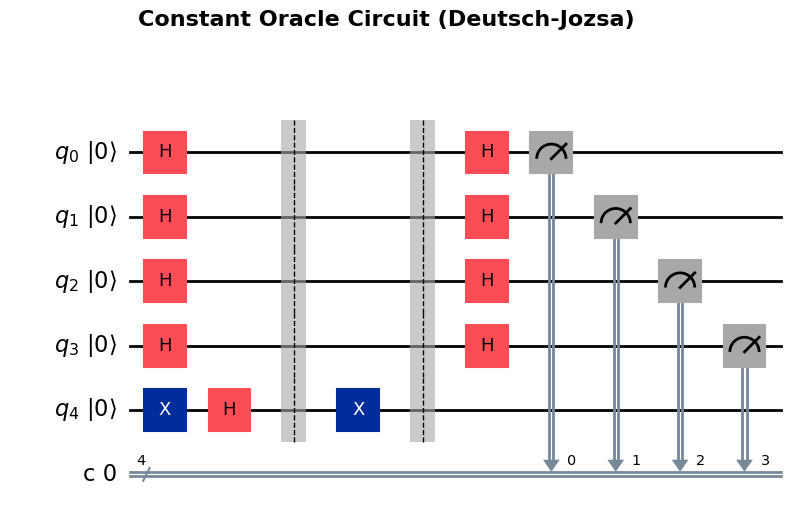

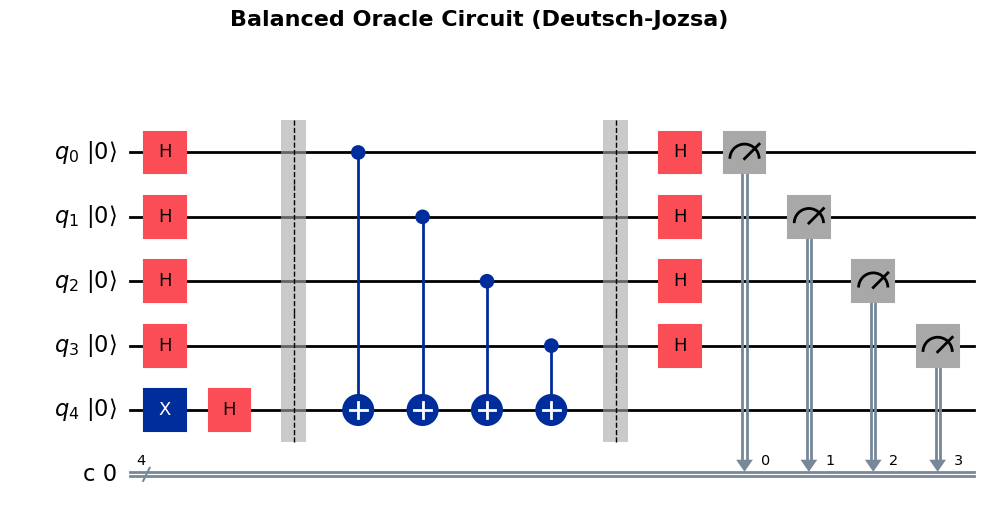

In [ ]:
draw_style = { "output": "mpl", "style": "iqp", "scale": 1, "fold": -1, "initial_state": True }

circuit_constant = create_circuit(dj_oracle_constant, 4)
fig_const = circuit_constant.draw(**draw_style)
fig_const.suptitle("Constant Oracle Circuit (Deutsch-Jozsa)", fontsize=16, fontweight='bold', y=1.05)
display(fig_const)
plt.close(fig_const)

print("\n" * 2)

circuit_balanced = create_circuit(dj_oracle_balanced, 4)
fig_bal = circuit_balanced.draw(**draw_style)
fig_bal.suptitle("Balanced Oracle Circuit (Deutsch-Jozsa)", fontsize=16, fontweight='bold', y=1.05)
display(fig_bal)
plt.close(fig_bal)

## Validation and Simulation
This final section benchmarks the algorithm's performance by stress-testing it across various sizes ($n$).

### Part 1. Automated Register Scaling
The system generates a `random_qubits_list` with values ranging from **3 to 60 qubits**. This proves the **parameterized architecture** of our circuit:

* **Test:** Handling a high number of qubits ($n=60$) would be computationally expensive for a classical brute-force.

* **Setup:** For every test, the circuit automatically scales the data register and adds the necessary ancilla, ensuring the **Phase Kickback** is mapped correctly regardless of size.

### Part 2. High-Performance Simulation
Utilize the **Aer Simulator** specifically configured with the `stabilizer` method.

* **Simulator:** `AerSimulator(method="stabilizer")`

* **Why this method?** Since the Deutsch-Jozsa circuit primarily uses Clifford gates (Hadamard, CNOT, X), the stabilizer simulator allows us to run circuits with 60+ qubits in seconds—something a standard statevector simulator would struggle to do.

* **Efficiency:** While a classical computer might need multiple queries to be certain, our quantum simulation confirms the function type in a **single shot** per test.

### Part 3. Deterministic Result Check
The system validates the measurement results against the expected mathematical outcome:
* **Constant Check:** The test passes only if the output string consists entirely of zeros ($00\dots0$).

* **Balanced Check:** The test passes if the output string contains at least one '1', signaling destructive interference at the zero state.

* **Visualizing Large Strings:** For registers wider than 15 qubits, the output is truncated to keep the report clean.

### Benchmark Results
The table below summarizes the execution across different qubit widths. The **Status** columns confirm whether the quantum measurement correctly identified the hidden nature of the oracle.

| N Qubits | Constant Output | Constant Status | Balanced Output | Balanced Status |
| :--- | :--- | :--- | :--- | :--- |
| *Random N* | `0000...` | **OK** | `1011...` | **OK** |

In [ ]:
import random
import pandas as pd
from qiskit_aer import AerSimulator

random_qubits_list = [random.randint(3, 60) for _ in range(5)]
simulator = AerSimulator(method="stabilizer")
simulation_data = []

for n in random_qubits_list:

    qc_const = create_circuit(dj_oracle_constant, n)
    res_const = simulator.run(qc_const).result().get_counts()
    out_const = max(res_const, key=res_const.get)
    check_const = "OK" if all(c == '0' for c in out_const) else "FAIL"

    qc_bal = create_circuit(dj_oracle_balanced, n)
    res_bal = simulator.run(qc_bal).result().get_counts()
    out_bal = max(res_bal, key=res_bal.get)
    check_bal = "OK" if any(c == '1' for c in out_bal) else "FAIL"

    out_const_visual = out_const if len(out_const) < 15 else out_const[:10] + "..."
    out_bal_visual = out_bal if len(out_bal) < 15 else out_bal[:10] + "..."

    simulation_data.append({
        "N Qubits": n,
        "Constant Output": out_const_visual,
        "Constant Status": check_const,
        "Balanced Output": out_bal_visual,
        "Balanced Status": check_bal
    })

df = pd.DataFrame(simulation_data)

def style_status(val):
    color = '#228B22' if val == 'OK' else '#D22222'
    font_weight = 'bold'
    return f'color: {color}; font_weight: {font_weight}'

styled_df = df.style.format({"N Qubits": "{}"})\
    .hide(axis="index")\
    .set_caption("Deutsch-Jozsa Algorithm Benchmark Results")\
    .set_properties(**{'text-align': 'center', 'padding': '8px'})\
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('background-color', '#f4f4f4'), ('color', 'black'), ('font-weight', 'bold')]},
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '16px'), ('font-weight', 'bold'), ('color', '#333')]}
    ])\
    .map(style_status, subset=['Constant Status', 'Balanced Status'])

display(styled_df)

N Qubits,Constant Output,Constant Status,Balanced Output,Balanced Status
42,0000000000...,OK,1111111111...,OK
26,0000000000...,OK,1111111111...,OK
39,0000000000...,OK,1111111111...,OK
53,0000000000...,OK,1111111111...,OK
39,0000000000...,OK,1111111111...,OK
